# Linear Regression - Biase Variance Trade Off


These are the most common ways to prevent overfitting in neural networks:

* Get more training data.
- Reduce the capacity of the network.
        - No of learnable parameters in a model is often referred to as the model's "capacity".
        - Deep network means more mean more memory which means overfitting. Find the right size DNN
* Add weight regularization.
* Add dropout.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
df = pd.read_csv('D:\\Sandbox\\Github\\DATA\\kc_house_data.csv')

### Feature Engineering from Date

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].apply(lambda date:date.month)
df['year'] = df['date'].apply(lambda date:date.year)

In [4]:
df = df.drop('id',axis=1)
df = df.drop('zipcode',axis=1)
df = df.drop('date',axis=1)

In [5]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'year'],
      dtype='object')

### Scaling and Train Test Split

In [6]:
X = df.drop('price', axis=1)
y = df['price']

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train.shape

(17277, 19)

### Helping Functions

In [11]:
N_VALIDATION = X_test.shape[0] # int(1e3)
N_TRAIN = X_train.shape[0] #int(1e4)
BUFFER_SIZE = X_train.shape[0] #int(1e4)
BATCH_SIZE = 128 # 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
FEATURES = X_train.shape[1] # 19

In [12]:
N_VALIDATION

4320

In [13]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

#### Learning Rate

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                  0.001,
                  decay_steps=STEPS_PER_EPOCH*1000,
                  decay_rate=1,
                  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

#### Call backs

In [15]:
def get_callbacks(name):
  return [
   # tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    #tf.keras.callbacks.TensorBoard(logdir/name),
  ]

#### Model Compile and Fit

In [16]:
from tensorflow.keras.losses import BinaryCrossentropy

def compile_and_fit(model, name, optimizer=None, max_epochs=100):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=BinaryCrossentropy(from_logits=True),
                metrics=[BinaryCrossentropy(from_logits=True, name='binary_crossentropy')]
                #metrics=[BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                      #  'accuracy']
               )

  model.summary()

  history = model.fit(
                        x = X_train, y= y_train,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=(X_test,y_test),
                        callbacks=get_callbacks(name),
                        verbose=0)

  return history

### Multiple Models

#### Tiny Model

In [17]:
tiny_model = tf.keras.Sequential([
    layers.Dense(19, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [18]:
size_histories = {}

In [19]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny', max_epochs = 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                380       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 20        
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


#### Small Model

In [20]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(19, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(19, activation='elu'),
    layers.Dense(1)
])

In [21]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs = 100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_3 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 20        
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________


#### Medium Model

In [22]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [23]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium",  max_epochs = 100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1280      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________


#### Large Model

In [24]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Large'] = compile_and_fit(large_model, "sizes/large", max_epochs = 100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               10240     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 798,721
Trainable params: 798,721
Non-trainable params: 0
_________________________________________________________________


In [26]:
size_histories

{'Tiny': <tensorflow.python.keras.callbacks.History at 0x1fabc119cd0>,
 'Small': <tensorflow.python.keras.callbacks.History at 0x1fabdb9b5b0>,
 'Medium': <tensorflow.python.keras.callbacks.History at 0x1fabf240340>,
 'Large': <tensorflow.python.keras.callbacks.History at 0x1fabd9db940>}

In [27]:
#losses = pd.DataFrame(size_histories['Tiny'].history)
#losses
#losses.plot()

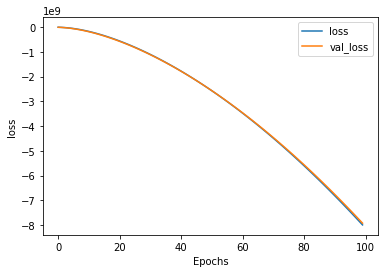

In [28]:
plot_graphs(size_histories['Tiny'], "loss")

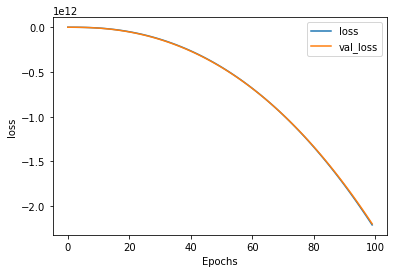

In [29]:
plot_graphs(size_histories['Small'], "loss")

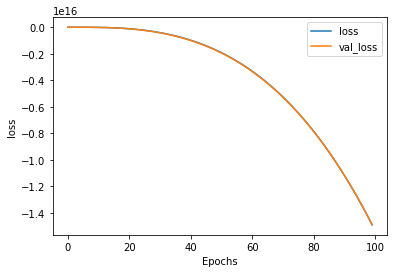

In [30]:
plot_graphs(size_histories['Medium'], "loss")

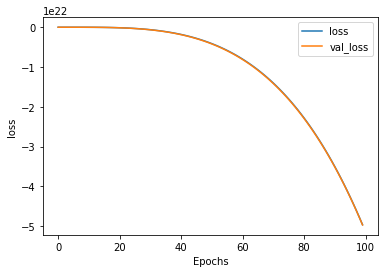

In [31]:
plot_graphs(size_histories['Large'], "loss")

### Strategies to prevent overfitting

In [32]:
regularizer_histories = {}

#### Regularization

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: 
Weight decay is mathematically the exact same as L2 regularization.

In [40]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2", max_epochs=20)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               10240     
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 513       
Total params: 798,721
Trainable params: 798,721
Non-trainable params: 0
_________________________________________________________________


#### Dropout

In [41]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout", max_epochs=20)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               10240     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)              

In [42]:
regularizer_historiesv

NameError: name 'regularizer_historiesv' is not defined

#### Combining Regularization and Dropout

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined", max_epochs=20)

In [43]:
regularizer_histories

{'l2': <tensorflow.python.keras.callbacks.History at 0x1fac4c1e490>,
 'combined': <tensorflow.python.keras.callbacks.History at 0x1fac3b7d700>,
 'dropout': <tensorflow.python.keras.callbacks.History at 0x1fac6f7ba00>}

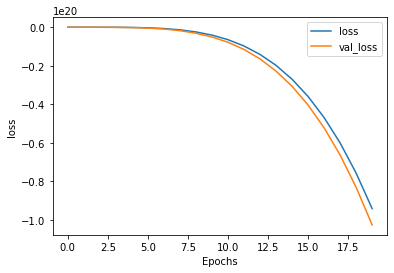

In [44]:
plot_graphs(regularizer_histories['l2'], "loss")

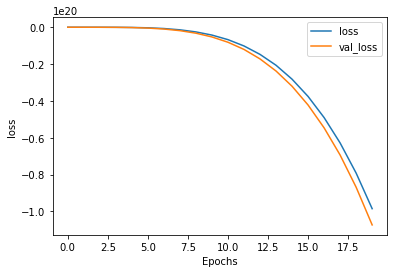

In [45]:
plot_graphs(regularizer_histories['dropout'], "loss")

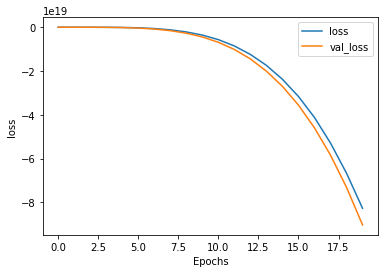

In [46]:
plot_graphs(regularizer_histories['combined'], "loss")